# Learning Experiment

In [1]:
from draco.learn import linear
from draco.learn import data_util
from draco.run import run
from draco.spec import Task, Query, AspTask, Encoding, Field, Data
from draco.learn.helper import count_violations
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import logging
from vega3 import VegaLite

logging.basicConfig()
logging.getLogger().setLevel(logging.WARN)

In [2]:
data, _ = data_util.load_data(test_size=0)
data = data[data.source != 'manual']

raw_data = data_util.load_neg_pos_specs()

data_yh = data[data.source == 'younghoon'] 
data_bh = data[data.source == 'bahador']

X = data.negative - data.positive
X_yh = data_yh.negative - data_yh.positive
X_bh = data_bh.negative - data_bh.positive

In [3]:
len(data_yh), len(X_yh), len(X_bh), len(data_bh)

(1152, 1152, 10, 10)

In [4]:
X_yh_train, X_yh_test = train_test_split(X_yh, test_size=0.3)
X_bh_train, X_bh_test = train_test_split(X_bh, test_size=0.3)

In [5]:
clf = linear.train_model(pd.concat([X_yh_train, X_bh]), test_size=0.3)
print()
print(clf.score(X, np.ones(len(X))))
print(clf.score(X_yh_test, np.ones(len(X_yh_test))))
print(clf.score(X_bh, np.ones(len(X_bh))))

Train score:  0.9299474605954466
Dev score:  0.9346938775510204

0.9294320137693631
0.9248554913294798
1.0


In [6]:
clf = linear.train_model(X_bh, test_size=0)

clf.score(X_bh, np.ones(len(X_bh)))

Train score:  1.0


1.0

In [7]:
clf = linear.train_model(X_yh_train, test_size=0.3)

clf.score(X_yh_test, np.ones(len(X_yh_test)))

Train score:  0.9237588652482269
Dev score:  0.9297520661157025


0.9104046242774566

# Apply a learned model to partial specifications

See whether it comes up with the optimum

In [8]:
clf = linear.train_model(X, test_size=0)

Train score:  0.9320137693631669


In [9]:
weights = clf.coef_[0]
names = X.columns

const_dict = dict(zip(map(lambda x: f'{x}_weight', names), map(int, weights*10000)))

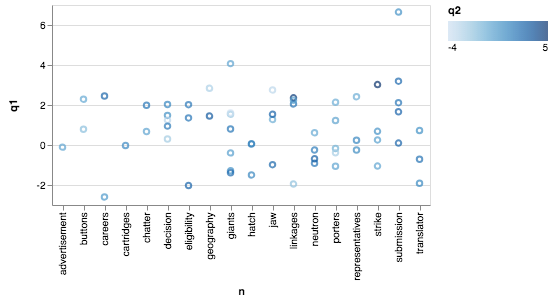

In [11]:
cardinalities = [3, 10, 20]
categories = [3, 30]
entropy = [0.8, 3.9]
tasks = ['value', 'summary']

cardinality = cardinalities[2]  # 0,1,2
num_cat = categories[0]  # 0,1
entropy_q1 = entropy[0]  # 0,1
entropy_q2 = entropy[0]  # 0,1
task = tasks[1]  # 0,1


fields = list(map(Field.from_obj, [
    {
      "name": "n",
      "type": "string",
      "entropy": 1,
      "cardinality": cardinality,
      "interesting": task == 'summary'
    },
    {
      "name": "q1",
      "type": "number",
      "entropy": entropy_q1,
      "cardinality": num_cat * cardinality,
      "interesting": True
    },
    {
      "name": "q2",
      "type": "number",
      "entropy": entropy_q2,
      "cardinality": num_cat * cardinality
    }
]))
spec_schema = Data(fields, num_cat * cardinality)
spec_schema.fill_with_random_content()

task = Task(spec_schema,
            Query(
                mark=None,
                encodings=[
                    Encoding(field='q1', ty='quantitative'),
                    Encoding(field='q2', ty='quantitative'),
                    Encoding(field='n', ty='nominal')
                ]),
            task=task
           )

out = run(task,
    constants=const_dict,
    files=['define.lp', 'generate.lp', 'test.lp', 'features.lp', 'weights.lp',
           'assign_weights.lp', 'optimize.lp', 'output.lp', 'younghoon.lp']
   )

spec = out.to_vegalite()
VegaLite(spec)